# Task 1

# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('Downloads/monthly-beer-production-in-austr.csv')

In [3]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
df.shape

(476, 2)

In [5]:
df.rename(columns={"Monthly beer production": "Beer Production"}, inplace=True)

In [6]:
df.describe()

,Beer Production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


In [7]:
df.dtypes

Month               object
Beer Production    float64
dtype: object

# label encoding

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Month'] = encoder.fit_transform(df['Month'].astype(str))

# Summary statistics

In [9]:
mean_val = df['Beer Production'].mean()
median_val = df['Beer Production'].median()
std_val = df['Beer Production'].std()

f"Mean: {mean_val}, Median: {median_val}, Std Dev: {std_val}"

'Mean: 136.3953781512605, Median: 139.15, Std Dev: 33.73872458301115'

# Time series plot

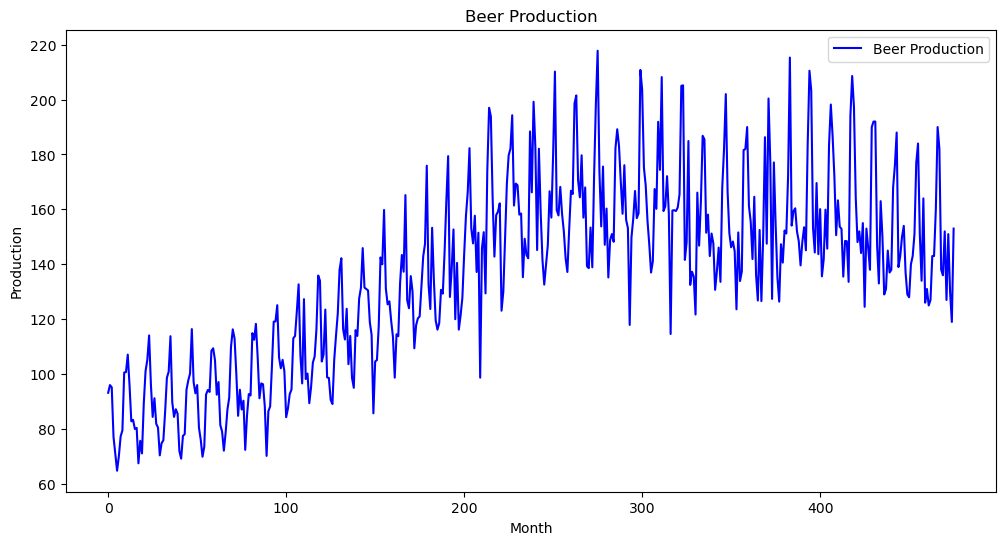

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Beer Production'], label="Beer Production", color="blue")
plt.title("Beer Production")
plt.xlabel("Month")
plt.ylabel("Production")
plt.legend()
plt.show()

# Correlation Heatmap

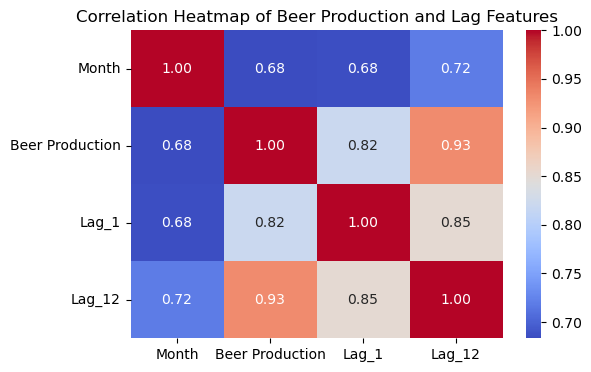

In [11]:
df.columns = df.columns.str.strip()

# Create lag features safely
df['Lag_1'] = df['Beer Production'].shift(1)
df['Lag_12'] = df['Beer Production'].shift(12)

# Drop NaN rows created by lagging
corr_df = df.dropna()

plt.figure(figsize=(6,4))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Beer Production and Lag Features")
plt.show()

# Seasonal Decomposition

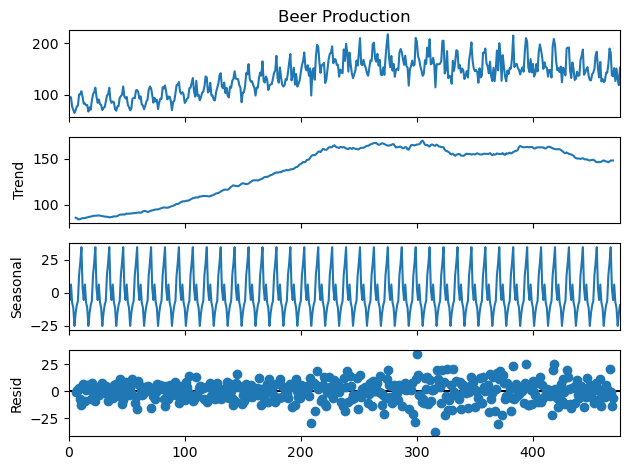

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Beer Production'], model='additive', period=12)

result.plot()
plt.show()

# Task 2

# Missing values

In [13]:
# Forward fill missing values
df['Beer Production'] = df['Beer Production'].fillna(method='ffill')

# Interpolate remainin gaps
df['Beer Production'] = df['Beer Production'].interpolate(method='linear')

C:\Users\sanju\AppData\Local\Temp\ipykernel_28096\3163708856.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Beer Production'] = df['Beer Production'].fillna(method='ffill')


# Detect and Handle Outliers

In [14]:
from scipy import stats

# IQR method
Q1 = df['Beer Production'].quantile(0.25)
Q3 = df['Beer Production'].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = df[(df['Beer Production'] < (Q1 - 1.5 * IQR)) | 
                  (df['Beer Production'] > (Q3 + 1.5 * IQR))]

# Z-score method
z_scores = np.abs(stats.zscore(df['Beer Production']))
outliers_z = df[z_scores > 3]

print("IQR outliers:", len(outliers_iqr))
print("Z-score outliers:", len(outliers_z))

df['Beer Production'] = np.where(z_scores > 3, df['Beer Production'].median(), df['Beer Production'])

IQR outliers: 0
Z-score outliers: 0


# Time-Based Features

In [17]:
# Create Season feature
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['Season'] = df['Month'].apply(get_season)

# Encode Season numerically
df['Season'] = df['Season'].map({"Winter":0, "Spring":1, "Summer":2, "Autumn":3})

df['Lag_1'] = df['Beer Production'].shift(1)
df['Lag_12'] = df['Beer Production'].shift(12)

df.dropna(inplace=True)

# Correlation Analysis

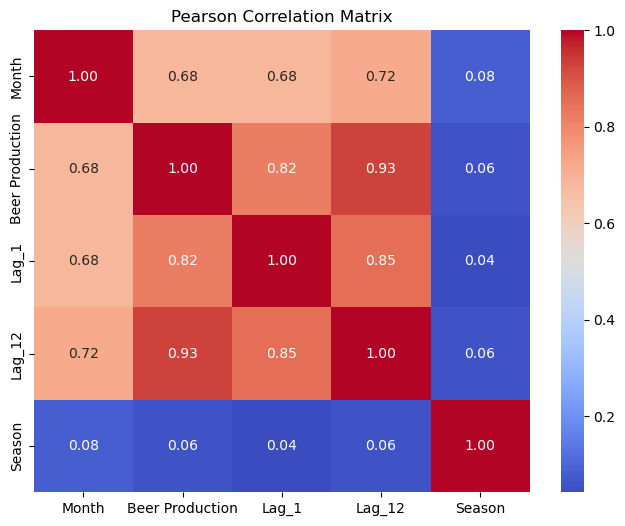

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

# Normalization

In [19]:
from sklearn.preprocessing import StandardScaler

# Select features excluding target variable
X = df.drop(columns=['Beer Production'])
y = df['Beer Production']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, index=df.index, columns=X.columns)

# Task 3

# Data preparation

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
X = df.drop(columns=['Beer Production'])
y = df['Beer Production']

# Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, shuffle=False)

# Linear Regression Model

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Prediction and Evaluation

y_val_pred_lr = lin_reg.predict(X_val)
y_test_pred_lr = lin_reg.predict(X_test)

mse_lr = mean_squared_error(y_val, y_val_pred_lr)
mae_lr = mean_absolute_error(y_val, y_val_pred_lr)
r2_lr = r2_score(y_val, y_val_pred_lr)

print("Linear Regression - Validation")
print(f"MSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.2f}")

Linear Regression - Validation
MSE: 230.81, MAE: 12.04, R²: 0.47


# Random Forest Regressor and Hyperparameter Tuning

In [23]:
rf = RandomForestRegressor(random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# Prediction and Evaluation

y_val_pred_rf = best_rf.predict(X_val)
y_test_pred_rf = best_rf.predict(X_test)

mse_rf = mean_squared_error(y_val, y_val_pred_rf)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

print("Random Forest - Validation")
print(f"MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest - Validation
MSE: 254.35, MAE: 12.16, R²: 0.42


# Feature Importance (Random Forest)

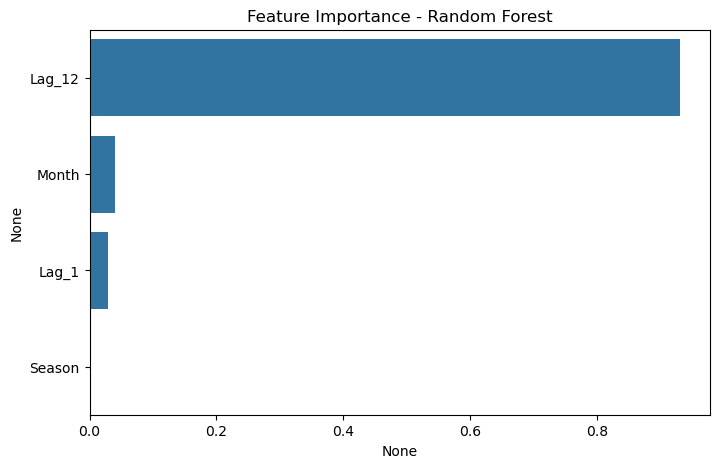

In [25]:
importances = best_rf.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance - Random Forest")
plt.show()

# Final Test Set Results

In [26]:
print("Final Test Results")

print("Linear Regression:")
print(f"MSE: {mean_squared_error(y_test, y_test_pred_lr):.2f}, "
      f"MAE: {mean_absolute_error(y_test, y_test_pred_lr):.2f}, "
      f"R²: {r2_score(y_test, y_test_pred_lr):.2f}")

print("\nRandom Forest:")
print(f"MSE: {mean_squared_error(y_test, y_test_pred_rf):.2f}, "
      f"MAE: {mean_absolute_error(y_test, y_test_pred_rf):.2f}, "
      f"R²: {r2_score(y_test, y_test_pred_rf):.2f}")

Final Test Results
Linear Regression:
MSE: 174.61, MAE: 10.86, R²: 0.63

Random Forest:
MSE: 117.09, MAE: 8.72, R²: 0.75


# Visualize Predictions vs Actual

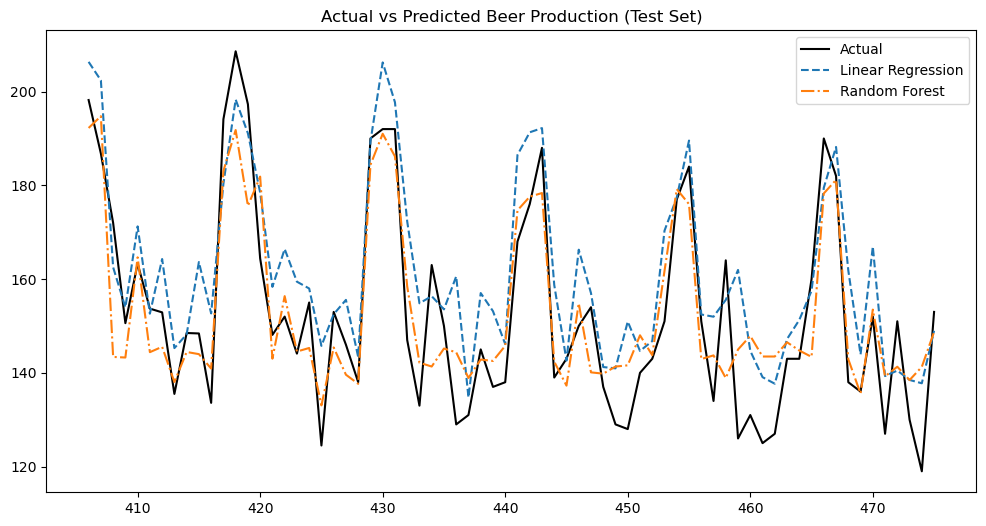

In [27]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual", color="black")
plt.plot(y_test.index, y_test_pred_lr, label="Linear Regression", linestyle="--")
plt.plot(y_test.index, y_test_pred_rf, label="Random Forest", linestyle="-.")
plt.legend()
plt.title("Actual vs Predicted Beer Production (Test Set)")
plt.show()